# Sentence Balancing Task


### Description of the problem

**Create the Dataset**


There are few options for the structure of the Sentence Balancing task
The nouns and adjectives are semantcally related

    - The [noun] is [adj] but the [-noun] is [-adj]
    - The [noun] is [adj] the [-noun] is [-adj]
    - The [-noun] is [adj] but the [noun] is [-adj]
    - The [-noun] is [adj] the [noun] is [-adj]

The nouns are not semantically related the adjectives are

    - The [noun1] is [adj] but the [noun2] is [-adj]
    - The [noun1]1 is [adj] the [noun2] is [-adj]


"The day is bright but the night is",
 "The summer is warm but the winter is",
 "The victory is sweet but the defeat is",
"The fire is warm but the ice is",
 "The war is bad but the peace is",
 "The man is strong but the woman is",
  "The comedy is funny but the tragedy is"



**We can separate the prompts in two groups**

    - The ones that predict a negative adjective
    - The ones that predict "not"

## How to check how the models performs this task?

A human would do the task in the following way:

    0) A human would know which is the task fot the [but] and the symmetry of lexical relations of the names
    1a) Look at the nouns
    1b) Look at the adjectives
    2a) What is the relationship between name1 and adjective1
    2b) What is the relationship between name1 and name2
    3) Infer the relationship between name2 and adjective2

## Stuff from the interpretability in the wild paper

**Which heads directly write to the output**

Identify which attention heads directly affect the model's output (the attention heads writting in the residual string at the END position in a direction that has high dot product with the logit differences)

we search for heads (i,j) such that 
$$
\lambda_{i,j} = E_{x ~ p_{n1,a,n2}}[{LN \dot h_{i,j}(x),W_{u}[adj2]-W_{u}[adj1]}]
$$

Check wether attention is correlated with the head's functionallity by scattering the attention probability against the logit score. $[h_i(X),W_U[adj2]]$



**Run experiments to find what heads inhibit the induction behavior**

# Integrated Gradients


In [ ]:
import torch
from torch.autograd import Variable
from transformers import GPT2Tokenizer, GPT2LMHeadModel

class SurrogateModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_embeds):
        return self.model(inputs_embeds=input_embeds)

# Initialize the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()

surrogate = SurrogateModel(model)
surrogate.eval()

# Start the autoregressive generation
input_text = "The day is bright but the night is"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
input_embeds = model.get_input_embeddings()(input_ids)

# Define the number of steps and baseline (the starting point for the path integral, usually the zero vector)
num_steps = 50
baseline = torch.zeros(input_embeds.shape)

# Loop over tokens¿
for _ in range(1):  # Generate 11 tokens
    baseline = torch.zeros_like(input_embeds)

    with torch.no_grad():
        outputs = surrogate(input_embeds)

    # Get the prediction
    predicted_token = torch.argmax(outputs.logits[..., -1, :]).item()

    # Calculate the attributions
    attributions = torch.zeros(input_embeds.shape)
    for i in range(num_steps):
        step_input = baseline + (input_embeds - baseline) * (i / num_steps)

        step_input_var = Variable(step_input, requires_grad=True)
        step_outputs = surrogate(step_input_var)

        # Compute gradients
        one_hot_output = torch.zeros_like(step_outputs.logits)
        one_hot_output[..., -1, predicted_token] = 1
        surrogate.zero_grad()
        step_outputs.logits.backward(gradient=one_hot_output)
        grad = step_input_var.grad.data

        attributions += grad / num_steps

    # Extend the input with the predicted token
    input_ids = torch.cat([input_ids, torch.tensor([[predicted_token]])], dim=-1)
    input_embeds = model.get_input_embeddings()(input_ids)



    tokens  attributions
0      The    136.311264
1      day    131.305237
2       is     91.028763
3   bright     54.878288
4      but     48.081940
5      the     50.912678
6    night     52.097404
7      iss    140.944321


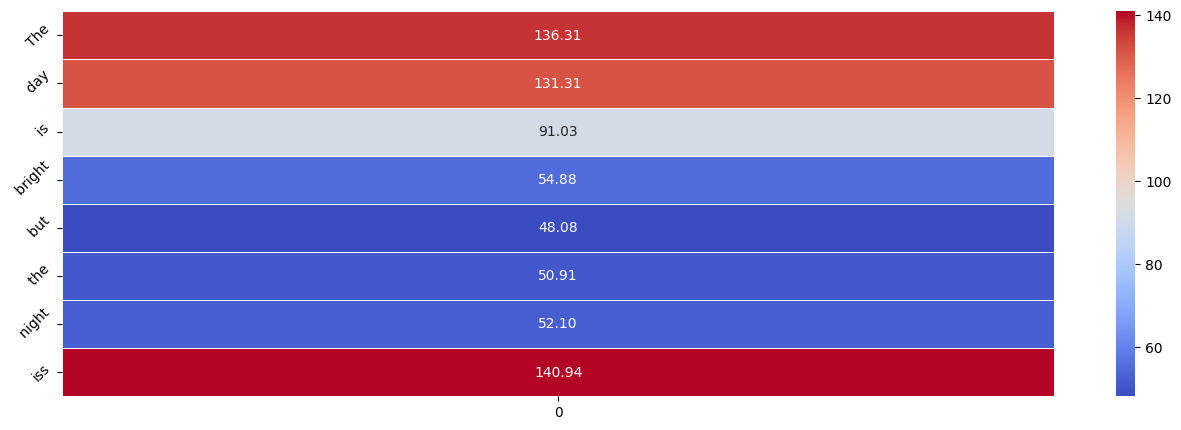

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get token-wise attribution by summing over the embedding dimension
token_attributions = attributions.norm(dim=-1).squeeze(0).detach().numpy()

# Convert token ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
# Prepare a DataFrame for visualization
df = pd.DataFrame({"tokens": [token.replace('Ġ', ' ') for token in tokens][:8], "attributions": token_attributions})
df.iloc[-1,0]="iss"
print(df)

# Convert 'attributions' column into a DataFrame, as Seaborn requires 2D data for a heatmap
df_attributions = pd.DataFrame(df['attributions'].values)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 5))

# Draw a heatmap with the numeric values in each cell
sns.heatmap(df_attributions, annot=True, fmt=".2f", linewidths=.5, ax=ax, cmap='coolwarm')

# Set the x-axis labels to be the tokens
ax.set_yticklabels(df["tokens"], rotation=45)

plt.show()



## Integrated gradients for all the prompts

In [ ]:
import torch
from torch.autograd import Variable
from transformers import GPT2Tokenizer, GPT2LMHeadModel

class SurrogateModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_embeds):
        return self.model(inputs_embeds=input_embeds)

# Initialize the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()

surrogate = SurrogateModel(model)
surrogate.eval()

# Define the number of steps and baseline (the starting point for the path integral, usually the zero vector)
num_steps = 50

# List of strings
input_texts = ["The day is bright but the night is",
 "The summer is warm but the winter is",
 "The victory is sweet but the defeat is",
"The fire is warm but the ice is",
 "The war is bad but the peace is",
 "The man is strong but the woman is",
  "The comedy is funny but the tragedy is"
    
  ]
all_tokens = []
all_attributions = []

# Loop over strings
for input_text in input_texts:

    # Start the autoregressive generation
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    input_embeds = model.get_input_embeddings()(input_ids)

    # Loop over tokens
    for _ in range(1):  # Generate 11 tokens
        baseline = torch.zeros_like(input_embeds)

        with torch.no_grad():
            outputs = surrogate(input_embeds)

        # Get the prediction
        predicted_token = torch.argmax(outputs.logits[..., -1, :]).item()

        # Calculate the attributions
        attributions = torch.zeros(input_embeds.shape)
        for i in tqdm(range(num_steps)):
            step_input = baseline + (input_embeds - baseline) * (i / num_steps)

            step_input_var = Variable(step_input, requires_grad=True)
            step_outputs = surrogate(step_input_var)

            # Compute gradients
            one_hot_output = torch.zeros_like(step_outputs.logits)
            one_hot_output[..., -1, predicted_token] = 1
            surrogate.zero_grad()
            step_outputs.logits.backward(gradient=one_hot_output)
            grad = step_input_var.grad.data

            attributions += grad / num_steps

        # Extend the input with the predicted token
        input_ids = torch.cat([input_ids, torch.tensor([[predicted_token]])], dim=-1)
        input_embeds = model.get_input_embeddings()(input_ids)

    # Store tokens and attributions
    all_tokens.append(tokenizer.convert_ids_to_tokens(input_ids[0]))
    all_attributions.append(attributions.norm(dim=-1).squeeze(0).detach().numpy())




NameError: name 'tqdm' is not defined

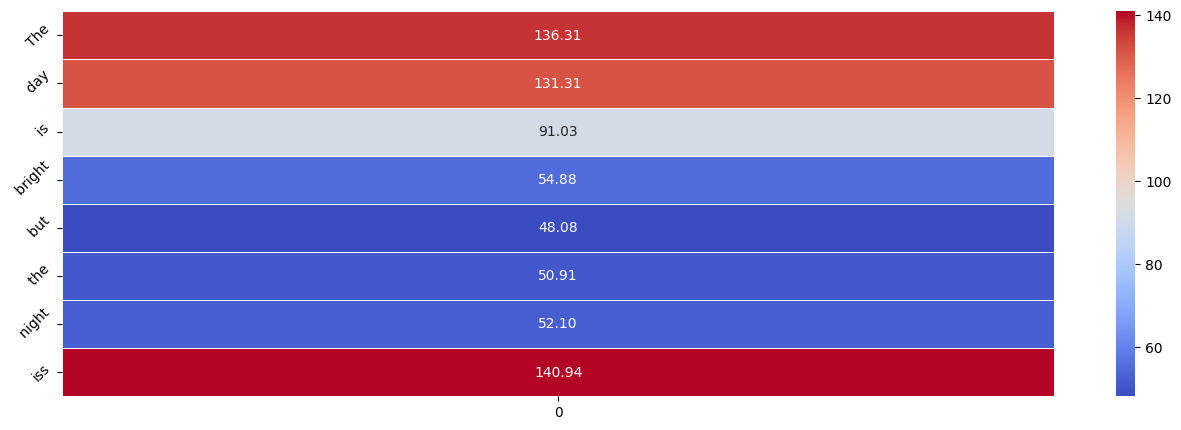

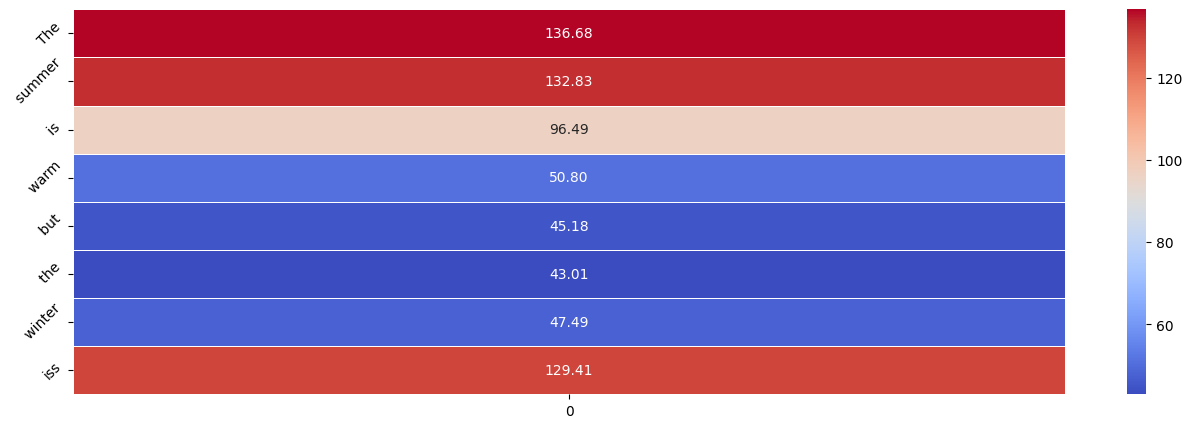

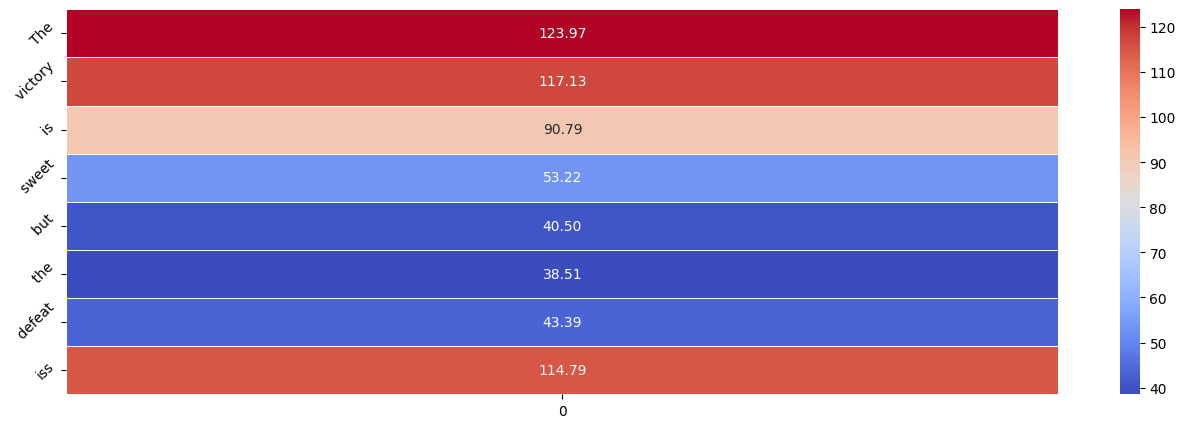

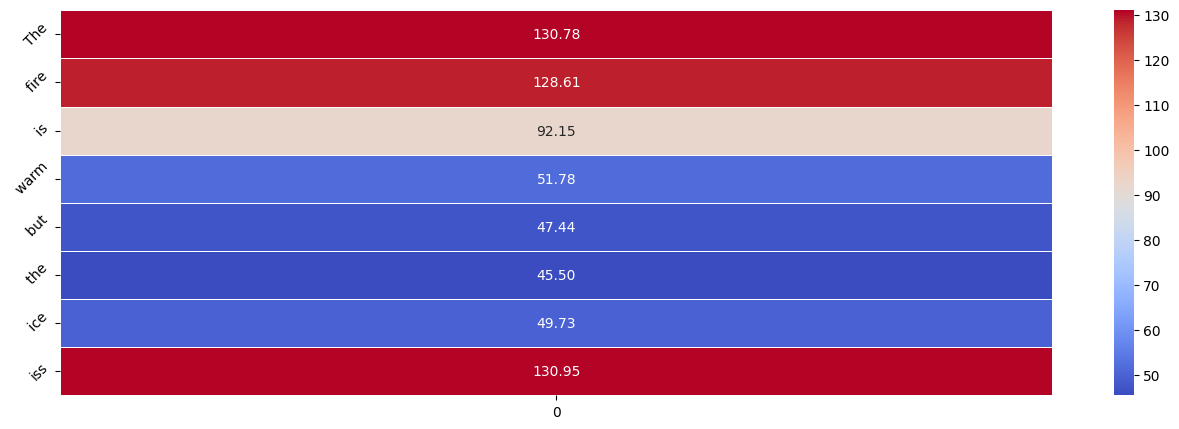

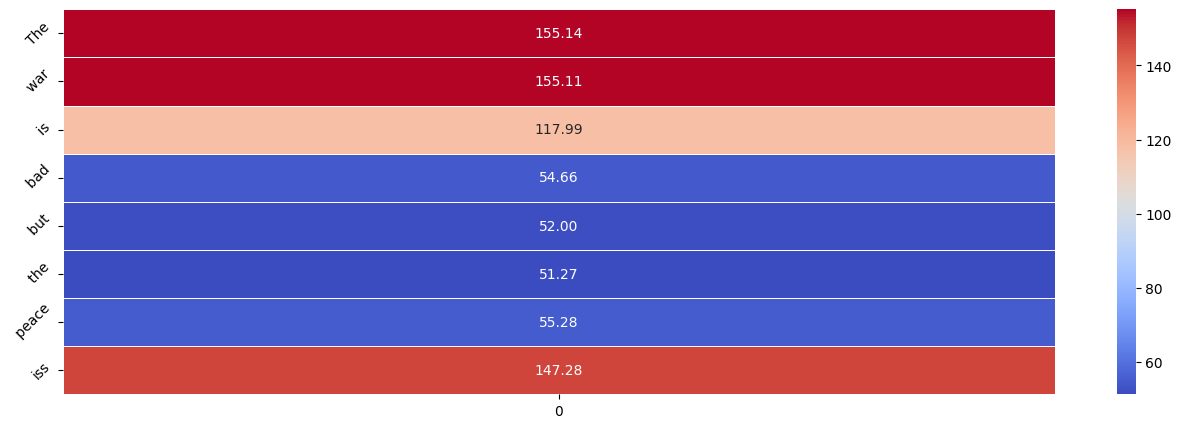

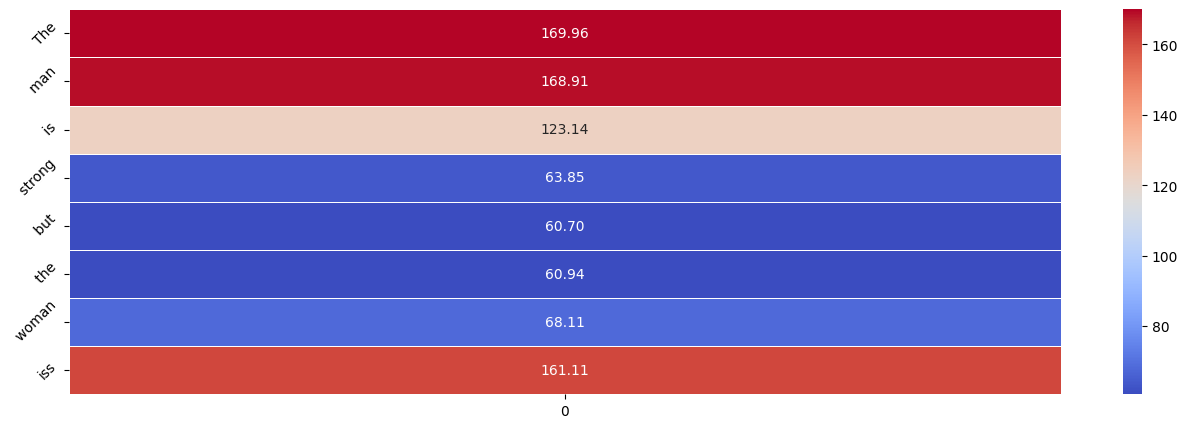

In [ ]:
# Plotting the heatmaps


for i in range(6):
    fig, axes = plt.subplots(figsize=(16, 5))
    ax=axes
    # Prepare a DataFrame for visualization
    df = pd.DataFrame({"tokens": [token.replace('Ġ', ' ') for token in all_tokens[i]][:8], "attributions": all_attributions[i]})
    df.iloc[-1,0] = "iss"
    df_attributions = pd.DataFrame(df['attributions'].values)

    # Draw a heatmap with the numeric values in each cell
    sns.heatmap(df_attributions, annot=True, fmt=".2f",linewidths=.5, ax=ax, cmap='coolwarm')

    # Set the x-axis labels to be the tokens
    ax.set_yticklabels(df["tokens"], rotation=45)
    plt.savefig(f'heatmap_{i}.png')
    plt.show()


## Integrated gradients with non zero baseline

In [ ]:

baseline=tokenizer.encode("The<|endoftext|>is<|endoftext|> but the<|endoftext|>is")
baseline=torch.tensor(baseline)
baseline=model.get_input_embeddings()(baseline)

/home/gerard/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [ ]:
import torch
from torch.autograd import Variable
from transformers import GPT2Tokenizer, GPT2LMHeadModel

class SurrogateModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_embeds):
        return self.model(inputs_embeds=input_embeds)

# Initialize the model and tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()

surrogate = SurrogateModel(model)
surrogate.eval()

# Define the number of steps and baseline (the starting point for the path integral, usually the zero vector)
num_steps = 200

# List of strings
input_texts = ["The day is bright but the night is",
 "The summer is warm but the winter is",
 "The victory is sweet but the defeat is",
"The fire is warm but the ice is",
 "The war is bad but the peace is",
 "The man is strong but the woman is",
  "The comedy is funny but the tragedy is"
    
  ]
all_tokens = []
all_attributions = []

# Loop over strings
for input_text in input_texts:

    # Start the autoregressive generation
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    input_embeds = model.get_input_embeddings()(input_ids)

    # Loop over tokens
    for _ in range(1):  # Generate 11 tokens
        

        with torch.no_grad():
            outputs = surrogate(input_embeds)

        # Get the prediction
        predicted_token = torch.argmax(outputs.logits[..., -1, :]).item()

        # Calculate the attributions
        attributions = torch.zeros(input_embeds.shape)
        for i in tqdm(range(num_steps)):
            step_input = baseline + (input_embeds - baseline) * (i / num_steps)

            step_input_var = Variable(step_input, requires_grad=True)
            step_outputs = surrogate(step_input_var)

            # Compute gradients
            one_hot_output = torch.zeros_like(step_outputs.logits)
            one_hot_output[..., -1, predicted_token] = 1
            surrogate.zero_grad()
            step_outputs.logits.backward(gradient=one_hot_output)
            grad = step_input_var.grad.data

            attributions += grad / num_steps

        # Extend the input with the predicted token
        input_ids = torch.cat([input_ids, torch.tensor([[predicted_token]])], dim=-1)
        input_embeds = model.get_input_embeddings()(input_ids)

    # Store tokens and attributions
    all_tokens.append(tokenizer.convert_ids_to_tokens(input_ids[0]))
    all_attributions.append(attributions.norm(dim=-1).squeeze(0).detach().numpy())




100%|██████████| 200/200 [02:36<00:00,  1.28it/s]


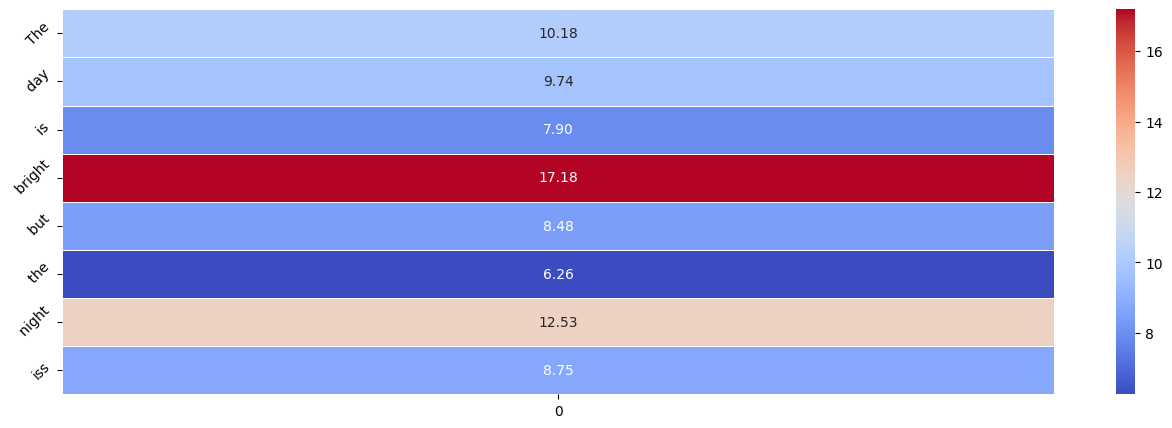

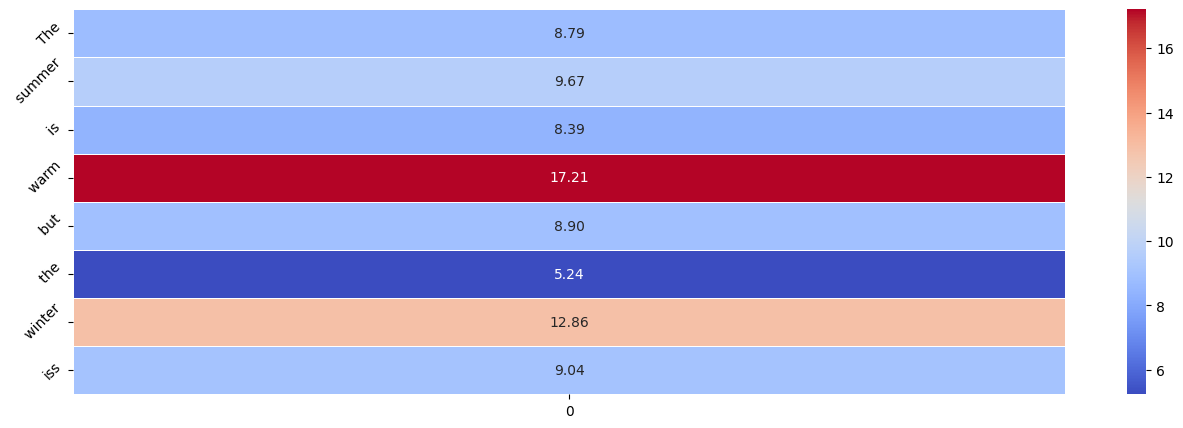

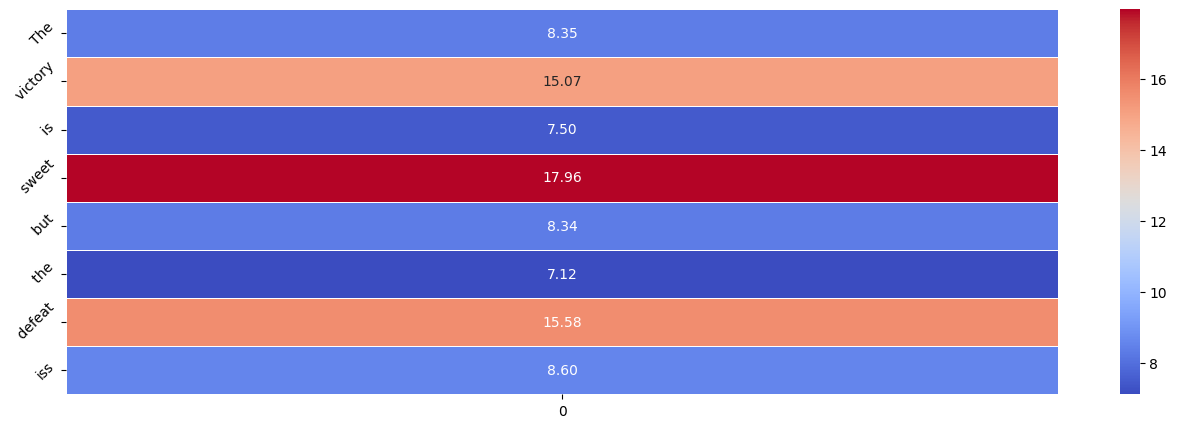

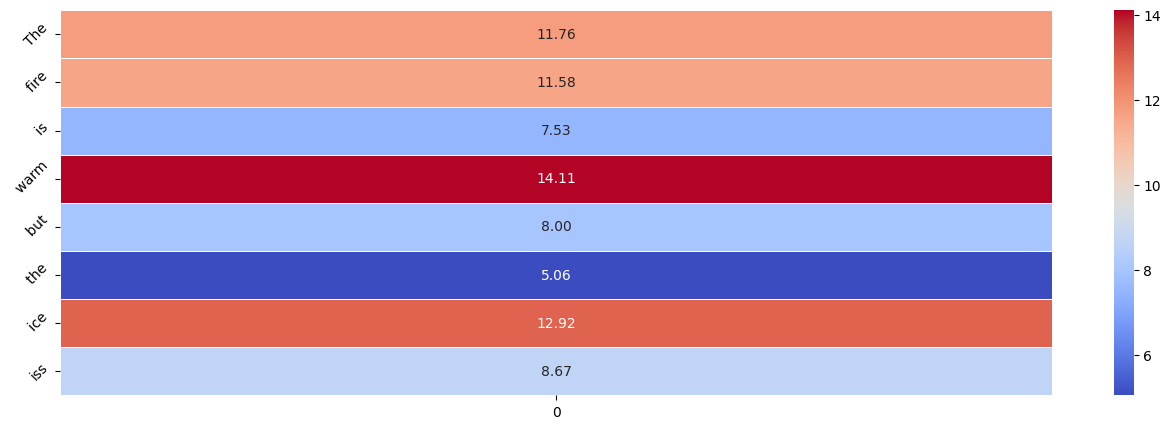

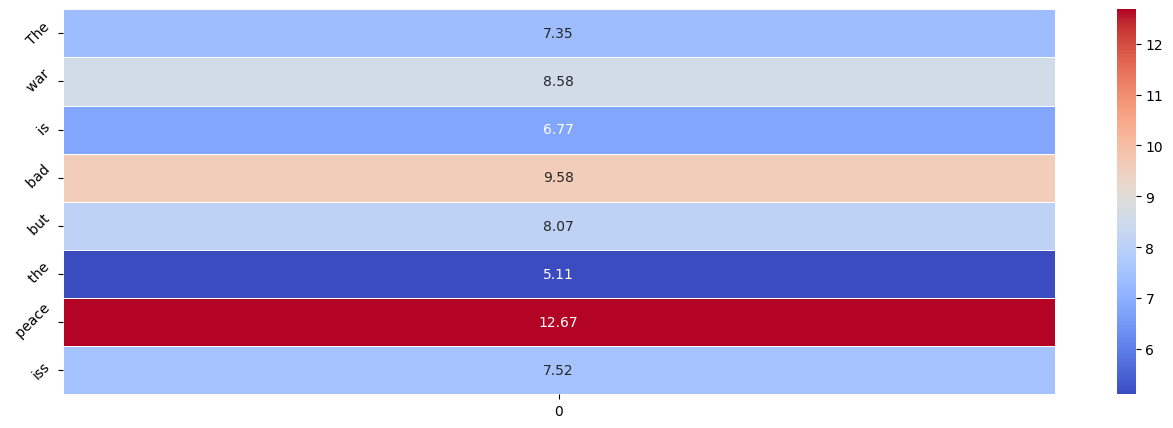

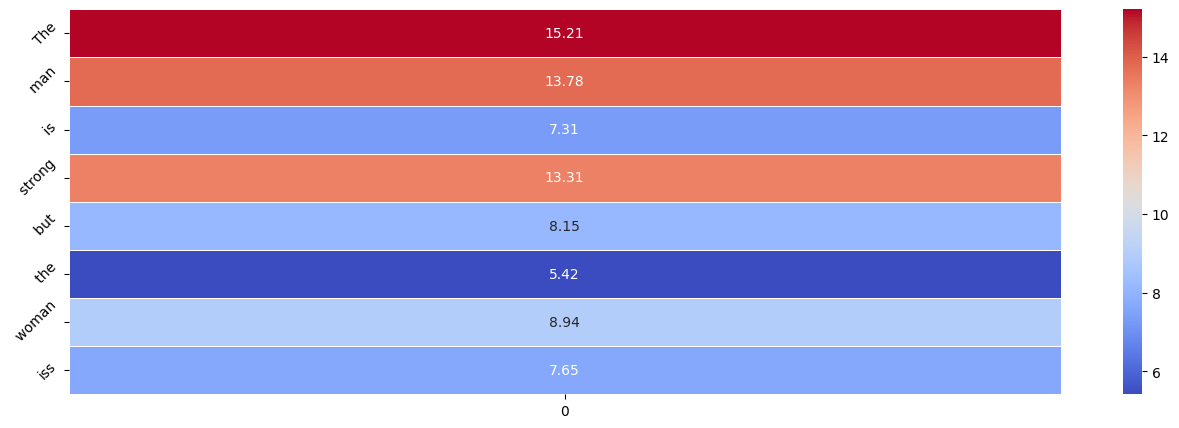

In [ ]:

for i in range(6):
    fig, axes = plt.subplots(figsize=(16, 5))
    ax=axes
    # Prepare a DataFrame for visualization
    df = pd.DataFrame({"tokens": [token.replace('Ġ', ' ') for token in all_tokens[i]][:8], "attributions": all_attributions[i]})
    df.iloc[-1,0] = "iss"
    df_attributions = pd.DataFrame(df['attributions'].values)

    # Draw a heatmap with the numeric values in each cell
    sns.heatmap(df_attributions, annot=True, fmt=".2f",linewidths=.5, ax=ax, cmap='coolwarm')

    # Set the x-axis labels to be the tokens
    ax.set_yticklabels(df["tokens"], rotation=45)
    plt.savefig(f'heatmap_{i}_non_zero_baseline.png')
    plt.show()

# LIME

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
from tqdm import tqdm

input_text = "The day is bright but the night is"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
print(len(input_ids[0]))
num_samples = 50  # Number of perturbations to generate
num_tokens = len(input_ids[0])  # Number of tokens in the input

# Function to generate a perturbed version of the input
def perturb_input(input_ids, mask):
    return input_ids * mask
print(len(input_ids[0]))

# Initialize a matrix to hold the perturbed inputs
perturbed_inputs = np.zeros((num_samples, num_tokens))
predictions = np.zeros(num_samples)

for i in tqdm(range(num_samples), desc='Generating perturbations'):
    # Generate a random mask
    mask = np.random.randint(0, 2, size=num_tokens)

    # Generate a perturbed input
    perturbed_input = perturb_input(input_ids[0].numpy(), mask)

    perturbed_inputs[i] = perturbed_input

    # Run the model on the perturbed input and store the prediction
    with torch.no_grad():
        perturbed_output = model(torch.tensor(perturbed_input).unsqueeze(0))


    predictions[i] = perturbed_output.logits[..., -1, :].max().item()

# Fit a linear regression model to the predictions
lr = LinearRegression()
lr.fit(perturbed_inputs, predictions)

# The coefficients of the linear regression model are the attributions
attributions = lr.coef_




8
8


Generating perturbations: 100%|██████████| 50/50 [00:05<00:00,  8.57it/s]


In [ ]:
import torch
from torch.autograd import Variable
from transformers import GPT2Tokenizer, GPT2LMHeadModel
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()
input_text = "The night is bright but the day is"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
model.generate(input_ids[0])

/home/gerard/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/gerard/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommen

IndexError: too many indices for tensor of dimension 2

0        The
1        day
2         is
3     bright
4        but
5        the
6      night
7         is
Name: tokens, dtype: object
0   -0.005472
1   -0.008729
2    0.006354
3    0.000366
4   -0.024014
5   -0.015162
6   -0.012535
7   -0.066223
Name: attributions, dtype: float64


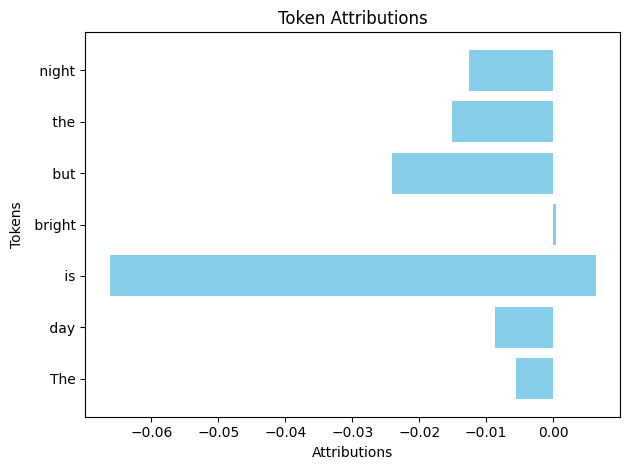

In [ ]:
import matplotlib.pyplot as plt

# Convert token ids to tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Prepare a DataFrame for visualization
df = pd.DataFrame({"tokens": [token.replace('Ġ', ' ') for token in tokens], "attributions": attributions})
print(df['tokens'])
print(df['attributions'])


# Create a horizontal bar plot
plt.barh(df['tokens'], df['attributions'], color='skyblue')

# Set labels
plt.xlabel('Attributions')
plt.ylabel('Tokens')
plt.title('Token Attributions')

plt.tight_layout()
plt.show()


In [ ]:
model

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

input_texts = ["The day is bright but the night is",
 "The summer is warm but the winter is",
 "The victory is sweet but the defeat is",
"The fire is warm but the ice is",
 "The war is bad but the peace is",
 "The man is strong but the woman is",
  "The comedy is funny but the tragedy is"
    
  ]
num_samples = 500  # Number of perturbations to generate

def perturb_input(input_ids, mask):
    return input_ids * mask

df_list = []

for input_text in tqdm(input_texts, desc='Processing input texts'):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    num_tokens = len(input_ids[0])  # Number of tokens in the input

    # Initialize a matrix to hold the perturbed inputs
    perturbed_inputs = np.zeros((num_samples, num_tokens))
    predictions = np.zeros(num_samples)

    for i in range(num_samples):
        # Generate a random mask
        mask = np.random.randint(0, 2, size=num_tokens)

        # Generate a perturbed input
        perturbed_input = perturb_input(input_ids[0].numpy(), mask)
        perturbed_inputs[i] = perturbed_input

        # Run the model on the perturbed input and store the prediction
        with torch.no_grad():
            perturbed_output = model(torch.tensor(perturbed_input).unsqueeze(0))
        predictions[i] = perturbed_output.logits[..., -1, :].max().item()

    # Fit a linear regression model to the predictions
    lr = LinearRegression()
    lr.fit(perturbed_inputs, predictions)

    # The coefficients of the linear regression model are the attributions
    attributions = lr.coef_
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Prepare a DataFrame for each input text and add to the list
    df_list.append(pd.DataFrame({
        "input_text": [input_text]*num_tokens,
        "tokens": [token.replace('Ġ', ' ') for token in tokens],
        "attributions": attributions
    }))

# Concatenate all DataFrames and save to CSV
df = pd.concat(df_list)
df.to_csv('attributions.csv', index=False)

Processing input texts: 100%|██████████| 7/7 [05:31<00:00, 47.42s/it]


We put a mask that disables changes in the structure

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

input_texts = ["The day is bright but the night is",
 "The summer is warm but the winter is",
 "The victory is sweet but the defeat is",
"The fire is warm but the ice is",
 "The war is bad but the peace is",
 "The man is strong but the woman is",
  "The comedy is funny but the tragedy is"
    
  ]
num_samples = 50  # Number of perturbations to generate
mask2=[True,False,True,False,True,True,False,True]
mask2_but=[True,False,True,False,False,True,False,True]
def perturb_input(input_ids, mask):
    mask=np.logical_or(mask,mask2_but)
    return input_ids * mask

df_list = []

for input_text in tqdm(input_texts, desc='Processing input texts'):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    num_tokens = len(input_ids[0])  # Number of tokens in the input

    # Initialize a matrix to hold the perturbed inputs
    perturbed_inputs = np.zeros((num_samples, num_tokens))
    predictions = np.zeros(num_samples)

    for i in range(num_samples):
        # Generate a random mask
        mask = np.random.randint(0, 2, size=num_tokens)
        mask_pre=[]
        # Generate a perturbed input
        perturbed_input = perturb_input(input_ids[0].numpy(), mask)
        perturbed_inputs[i] = perturbed_input

        # Run the model on the perturbed input and store the prediction
        with torch.no_grad():
            perturbed_output = model(torch.tensor(perturbed_input).unsqueeze(0))
        predictions[i] = perturbed_output.logits[..., -1, :].max().item()

    # Fit a linear regression model to the predictions
    lr = LinearRegression()
    lr.fit(perturbed_inputs, predictions)

    # The coefficients of the linear regression model are the attributions
    attributions = lr.coef_
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    
    # Prepare a DataFrame for each input text and add to the list
    df_list.append(pd.DataFrame({
        "input_text": [input_text]*num_tokens,
        "tokens": [token.replace('Ġ', ' ') for token in tokens],
        "attributions": attributions
    }))

# Concatenate all DataFrames and save to CSV
df = pd.concat(df_list)
df.to_csv('attributions_mask.csv', index=False)

Processing input texts: 100%|██████████| 7/7 [00:36<00:00,  5.24s/it]


In [ ]:
mask = np.random.randint(0, 2, size=num_tokens)
mask2=[True,False,True,False,True,True,False,True]

np.logical_or(mask,mask2)

# SHAP